In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import utils.DataSplitter
import utils.Pytorch
from utils.tools import plotFitAndPredictions, plotLossCurves
from utils.metrics import *

## Define models

In [2]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.multiplier = 1
        if bidirectional:
            self.multiplier = 2

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*self.multiplier, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*self.multiplier, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*self.multiplier, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


## Hyperparameter search

In [3]:
# Change accordingly
aggLevel = 60

if aggLevel == 60:
    multiplier = 1
elif aggLevel == 30:
    multiplier = 2
elif aggLevel == 15:
    multiplier = 4

# Variants
windowStrategy_list = [utils.Pytorch.fixedWindowPytorch]
line_list = ["1A"]
diff_list = [True, False]
useLags_list = [False, True]
dropWeather_list = [True, False]
dropCalendar_list = [True, False]

# Base model
base_model = {"lags": [],
              "hidden_size": 60,
              "num_layers": 2,
              "dropout_prob": 0.35,
              "bidirectional": True,
              "batch_size": 480,
              "epochs": 50,
              "max_lr": 1e-3}
base_model["lags"] = [lag*multiplier for lag in base_model["lags"]]

# Grid lists
list_of_lags = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                [1, 20, 140], 
                [1, 4, 8, 20],
                [1, 10, 20, 140],
                [1, 4, 8, 20, 140],
                [20, 40, 60, 80, 100, 120, 140],
                [1, 20, 40, 60, 80, 100, 120, 140]]
list_of_lags = [[lag*multiplier for lag in lags] for lags in list_of_lags]
hidden_size_list = [20, 40, 60, 80, 100]
num_layers_list = [2, 3]
dropout_prob_list = [0.1, 0.25, 0.35, 0.5, 0.75]
bidirectional_list = [True, False]
batch_size_list = [32, 160, 480, 704, 960]
epochs_list = [20, 30, 50, 75, 100]
max_lr_list = [1e-1, 1e-2, 1e-3, 1e-4]

for windowStrategy in windowStrategy_list:
    for line in line_list:
        for useLags in useLags_list:
            for dropCalendar in dropCalendar_list:
                for dropWeather in dropWeather_list:
                    if not useLags and dropCalendar and dropWeather:
                        continue

                    for diff in diff_list:
                        if useLags:
                            lags_list = deepcopy(list_of_lags)
                        else:
                            lags_list = [[]]

                        # Grid search
                        best_val_nMAE = np.Inf
                        for lags in lags_list:
                            X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                                             multiplier,
                                                                                                                                                             line,
                                                                                                                                                             diff,
                                                                                                                                                             lags,
                                                                                                                                                             dropWeather,
                                                                                                                                                             dropCalendar)
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["lags"] = lags
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                                         multiplier,
                                                                                                                                                         line,
                                                                                                                                                         diff,
                                                                                                                                                         base_model["lags"],
                                                                                                                                                         dropWeather,
                                                                                                                                                         dropCalendar)
                        for hidden_size in hidden_size_list:
                            model = LSTM(hidden_size=hidden_size, num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["hidden_size"] = hidden_size
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for num_layers in num_layers_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=num_layers, dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["num_layers"] = num_layers
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for dropout_prob in dropout_prob_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=dropout_prob, bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["dropout_prob"] = dropout_prob
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for bidirectional in bidirectional_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=bidirectional)
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["bidirectional"] = bidirectional
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for batch_size in batch_size_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=batch_size,
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["batch_size"] = batch_size
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for epochs in epochs_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=epochs,
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["epochs"] = epochs
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)

                        for max_lr in max_lr_list:
                            model = LSTM(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=max_lr,
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["max_lr"] = max_lr
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = nMAE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nMAE(y=y_val_true, yhat=y_val_pred)                                                                                            

                        with open(f"gridSearch/{model.__class__.__name__}GridSearch.txt", "a") as f:
                            f.write(f"Window: {windowStrategy.__doc__}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                            f.write("Best hyperparameters:\n")
                            f.write(f"lags: {base_model["lags"]}\n")
                            f.write(f"hidden size: {base_model["hidden_size"]}, layers: {base_model["num_layers"]}, dropout: {base_model["dropout_prob"]}, bidirectional: {base_model["bidirectional"]}\n")
                            f.write(f"batch size: {base_model["batch_size"]}, epochs: {base_model["epochs"]}, max_lr: {base_model["max_lr"]}\n")
                            f.write(f"Train metrics:\n")
                            f.write(f"nMAE: {best_train_nMAE}, MAPE: {best_train_MAPE}, nRMSE: {best_train_nRMSE}\n")
                            f.write(f"Val metrics:\n")
                            f.write(f"nMAE: {best_val_nMAE}, MAPE: {best_val_MAPE}, nRMSE: {best_val_nRMSE}\n")
                            f.write("------------------------------------------------------------------------------\n")

Epoch: 10, Train Loss: 0.994477893624987, Val Loss: 1.0069638291994731
Epoch: 20, Train Loss: 0.8608359027476538, Val Loss: 0.9187626540660858
Epoch: 30, Train Loss: 0.8435294230779012, Val Loss: 0.9165612856547037
Epoch: 40, Train Loss: 0.8337377111117045, Val Loss: 0.9156617025534312


KeyboardInterrupt: 

## Plot

In [6]:
# Change accordingly
aggLevel = 60
line = "1A"
diff = False
lags = [1, 20, 40, 60, 80, 100, 120, 140]  # [i+1 for i in range(20)] + [40, 60, 80, 100, 120, 140]  # <-- To use all columns
dropWeather = False
dropCalendar = False

if aggLevel == 60:
    multiplier = 1
elif aggLevel == 30:
    multiplier = 2
elif aggLevel == 15:
    multiplier = 4
lags = [lag*multiplier for lag in lags]

X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                 multiplier,
                                                                                                                                 line,
                                                                                                                                 diff,
                                                                                                                                 lags,
                                                                                                                                 dropWeather,
                                                                                                                                 dropCalendar)

In [7]:
model = LSTM(hidden_size=100, num_layers=3, dropout_prob=0.35, bidirectional=True)
model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(utils.Pytorch.fixedWindowPytorch,
                                                                                                             X_train,
                                                                                                             y_train,
                                                                                                             X_val,
                                                                                                             y_val,
                                                                                                             y_train_true,
                                                                                                             y_val_true,
                                                                                                             model=model,
                                                                                                             batchSize=32,
                                                                                                             epochs=50,
                                                                                                             max_lr=1e-3,
                                                                                                             device=device,
                                                                                                             lagColName=lagColName,
                                                                                                             horizon=40*multiplier)

Forecast iteration: 46


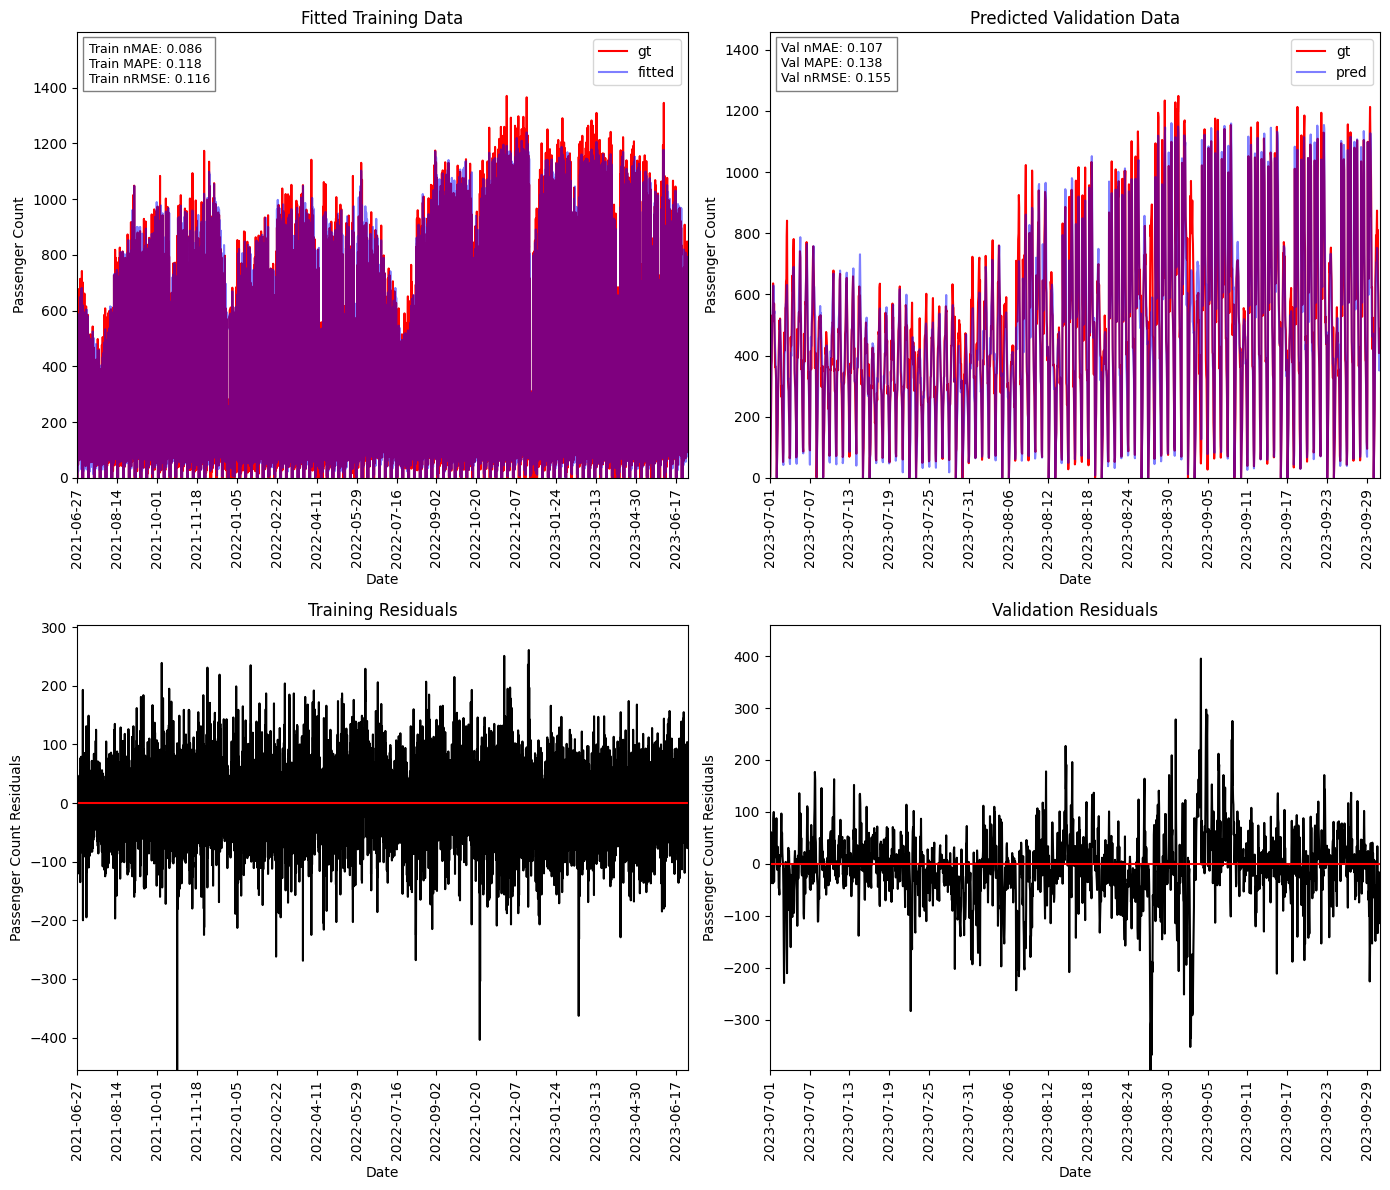

In [8]:
plotFitAndPredictions(y_train_pred, y_val_pred, y_train_true, y_val_true, trainDateCol=train_orig["date"], valDateCol=val_orig["date"])

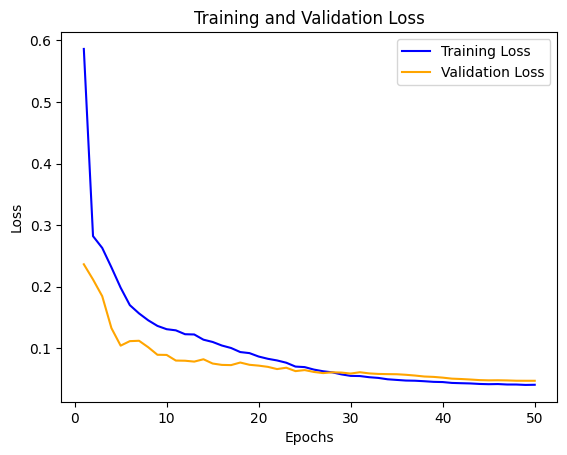

In [9]:
plotLossCurves(train_loss_list, val_loss_list, epoch_range)

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM